# Linear layers for three-second splits

~68% validation accuracy

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import pandas as pd
import numpy as np

In [2]:
import pickle

infile = open("Preprocessed/mfcc_list_time-series_639450_10_60",'rb')
mfcc_list = pickle.load(infile)
infile.close()

In [3]:
df = pd.read_csv("Data/features_30_sec.csv")

In [4]:
df['labels'] = range(0, 1000)

In [5]:
mfcc_list = mfcc_list.merge(df, on="labels", how="left")

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mfcc_list.mfcc, mfcc_list.label, test_size=0.2, random_state=42
)

y_test_keep = y_test

In [7]:
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer()
y_train = le.fit_transform(y_train.values)
y_test = le.transform(y_test.values)

In [8]:
class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.hidden_size = 1290
        drp = 0.1
        n_classes = 10
        self.fc1 = nn.Linear(125*60, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)
        # self.softmax = nn.Softmax(n_classes)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        fc1 = self.dropout(self.relu(self.fc1(x)))
        fc2 = self.dropout(self.relu(self.fc2(fc1)))
        fc3 = self.dropout(self.relu(self.fc3(fc2)))
        fc4 = self.dropout(self.relu(self.fc4(fc3)))
        fc5 = self.dropout(self.relu(self.fc5(fc4)))
        out = self.out(fc5)
        return out

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        drp = 0.1
        n_classes = len(le.classes_)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        
        self.cnn_layer1 = nn.Sequential(
            # Layer 1
            nn.Conv1d(40, 40, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(40),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Dropout(drp),
            # Layer 1
            nn.Conv1d(40, 40, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(40),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Dropout(drp),
        )
        
        # self.cnn_layer2 = nn.Sequential(
        #     # Layer 1
        #     nn.Conv1d(40, 40, kernel_size=5, stride=1, padding=2),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp),
        # )
        
        # self.cnn_layer2 = nn.Sequential(
        #     # Layer 2
        #     nn.Conv1d(40, 40, kernel_size=249, stride=1, padding=124),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp),
        # )
        # self.cnn_layer3 = nn.Sequential(
        #     # Layer 3
        #     nn.Conv1d(40, 40, kernel_size=125, stride=1, padding=62),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp),
        # )
        # self.cnn_layer4 = nn.Sequential(
        #     # Layer 4
        #     nn.Conv1d(40, 40, kernel_size=59, stride=1, padding=29),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp)
        # )
        
        self.fc1 = nn.Linear(125*40, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)
        self.directout = nn.Linear(512, n_classes)

    def forward(self, x):
        x = x.view(x.shape[0], 40, 125)
        out1 = self.cnn_layer1(x)
        # out2 = self.cnn_layer2(x)
        # out3 = self.cnn_layer3(x)
        # out4 = self.cnn_layer4(x)
        # full_out = torch.cat([out1, out2], dim=1)
        # full_out = full_out.view(full_out.size(0), -1)
        x = torch.flatten(out1, start_dim=1)
        x = self.fc1(x)
        out = self.directout(x)
        return out

In [10]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = F.softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    _, y_test_tags = torch.max(y_test, dim = 1) 
    
    correct_pred = (y_pred_tags == y_test_tags).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return y_pred_softmax, acc

In [11]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 50
batch_size = 128
model = Linear()
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001
)

model.to(device)

# Load train and test in CUDA Memory
x_train = torch.tensor(X_train.values.tolist(), dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
x_cv = torch.tensor(X_test.values.tolist(), dtype=torch.float).to(device)
y_cv = torch.tensor(y_test, dtype=torch.float).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train_tensor)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.0
    accuracy = []
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # # Casting
        # x_batch = x_batch.to(device)
        # y_batch = y_batch.type(torch.LongTensor)
        # y_batch = y_batch.to(device)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        _, acc = multi_acc(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
        accuracy.append(acc.item())

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.0
    val_accuracy = []
    val_preds = np.zeros((len(x_cv), 10))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        # Casting
        # x_batch = x_batch.to(device)
        # y_batch = y_batch.type(torch.LongTensor)
        # y_batch = y_batch.to(device)
        # Detach
        y_pred = model(x_batch).detach()
        val_pred, val_acc = multi_acc(y_pred, y_batch)
        val_preds[i * batch_size:(i+1) * batch_size] = val_pred
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        val_accuracy.append(val_acc.item())

    # Check Accuracy
    # val_accuracy = sum(val_preds.argmax(axis=1) == y_test) / len(y_test)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print(
        "Epoch {}/{} \t loss={:.4f} \t acc={:.2f}% \t val_loss={:.4f} \t val_acc={:.2f}% \t time={:.2f}s".format(
            epoch + 1, n_epochs, avg_loss, np.mean(accuracy), avg_val_loss, np.mean(val_accuracy), elapsed_time
        )
    )


Epoch 1/50 	 loss=285.7135 	 acc=21.05% 	 val_loss=263.1093 	 val_acc=31.69% 	 time=1.26s
Epoch 2/50 	 loss=262.9003 	 acc=30.73% 	 val_loss=238.3823 	 val_acc=36.31% 	 time=1.33s
Epoch 3/50 	 loss=243.3954 	 acc=34.83% 	 val_loss=219.5565 	 val_acc=40.94% 	 time=1.19s
Epoch 4/50 	 loss=227.7028 	 acc=38.10% 	 val_loss=205.9258 	 val_acc=43.56% 	 time=1.23s
Epoch 5/50 	 loss=216.4512 	 acc=40.89% 	 val_loss=195.4274 	 val_acc=47.44% 	 time=1.15s
Epoch 6/50 	 loss=205.6789 	 acc=43.11% 	 val_loss=187.4922 	 val_acc=48.31% 	 time=1.25s
Epoch 7/50 	 loss=199.1185 	 acc=45.49% 	 val_loss=181.1854 	 val_acc=50.81% 	 time=1.14s
Epoch 8/50 	 loss=191.1206 	 acc=47.38% 	 val_loss=174.9772 	 val_acc=52.50% 	 time=1.26s
Epoch 9/50 	 loss=184.9958 	 acc=49.51% 	 val_loss=169.0347 	 val_acc=54.44% 	 time=1.14s
Epoch 10/50 	 loss=178.9671 	 acc=50.68% 	 val_loss=166.0084 	 val_acc=55.06% 	 time=1.37s
Epoch 11/50 	 loss=172.4627 	 acc=53.06% 	 val_loss=163.2947 	 val_acc=55.19% 	 time=1.32s
Epoch 12

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_graph(epochs):
    plt.figure(figsize=(12,12), dpi=600)
    sns.set_style("ticks")
    plt.style.library['seaborn-colorblind'] # Care for the color-blind :")
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

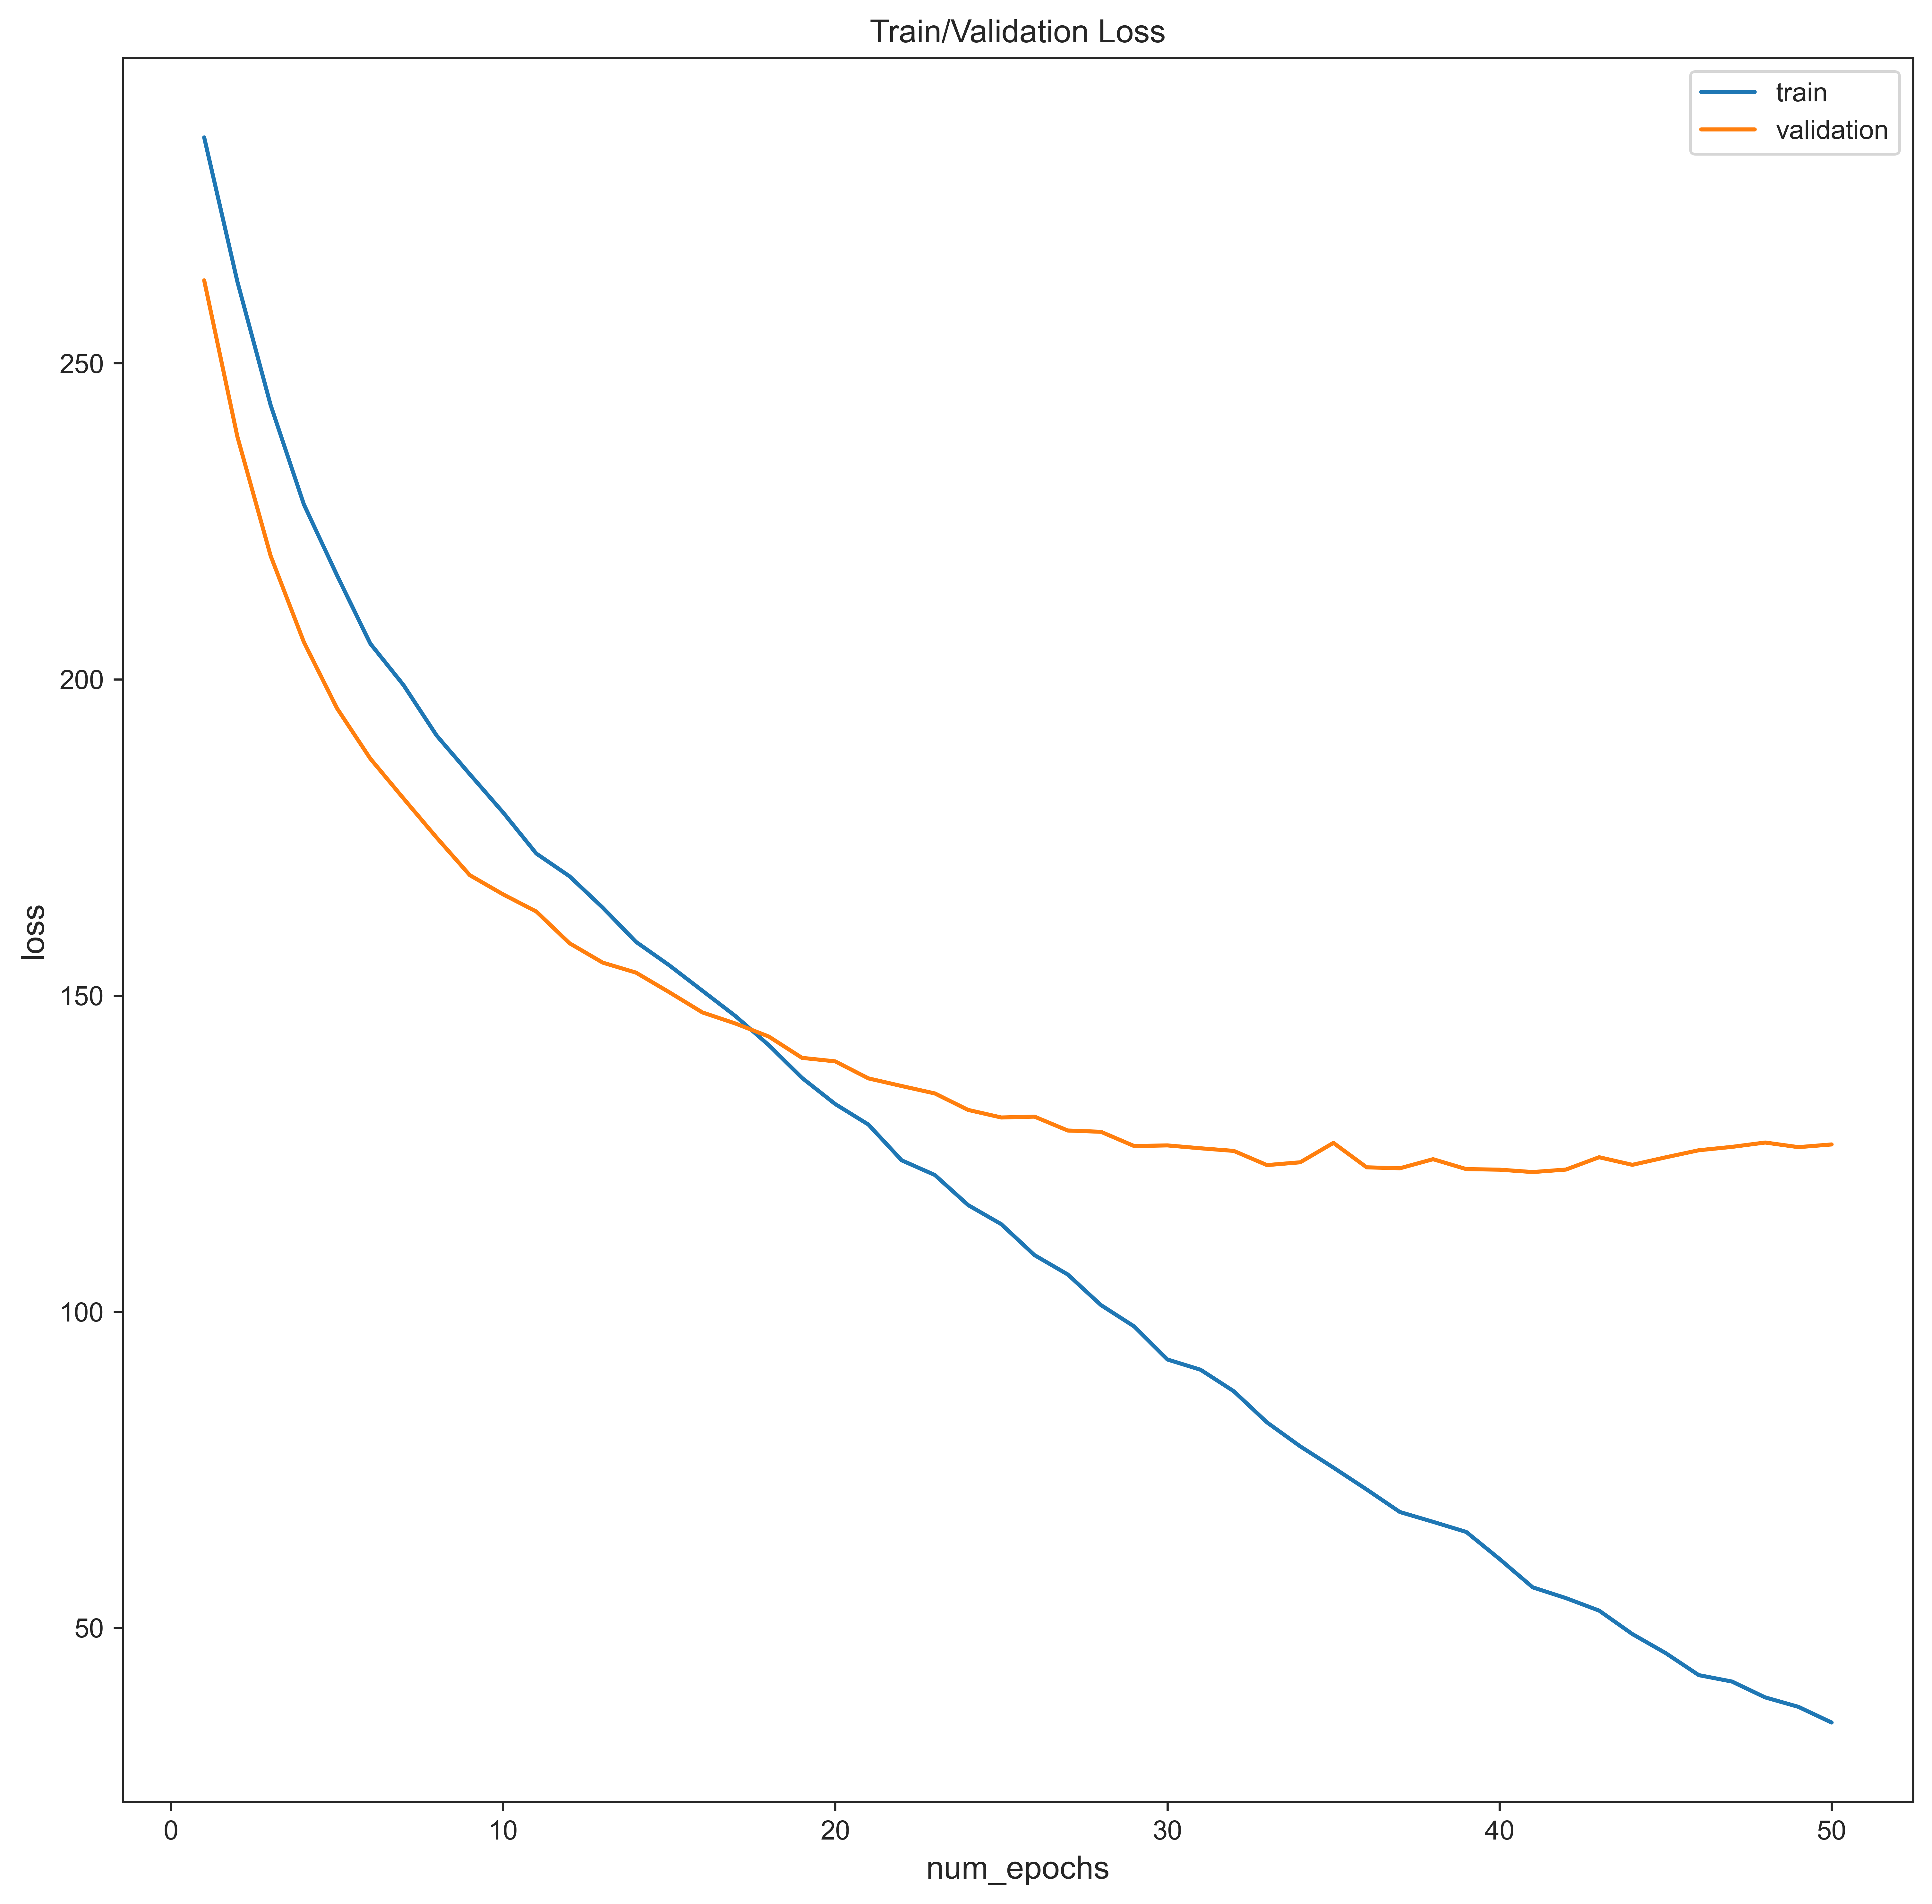

In [13]:
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

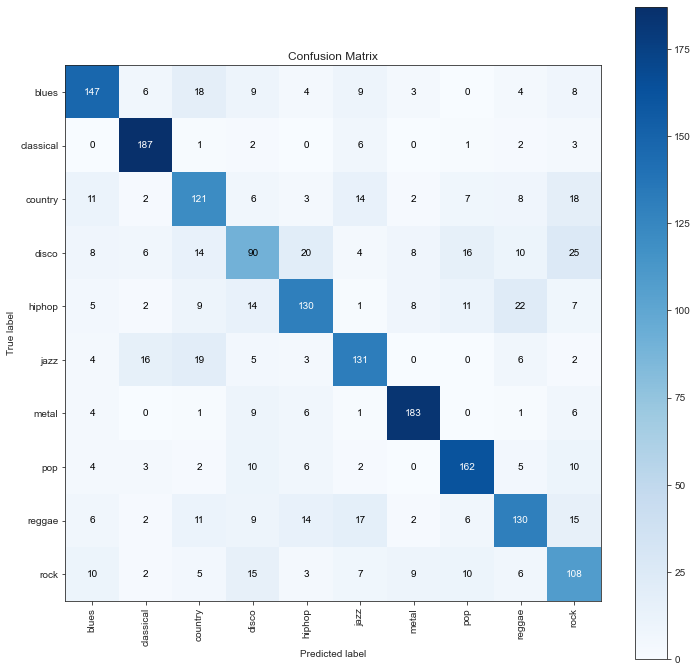

In [14]:
import scikitplot as skplt
y_true = [x for x in y_test_keep.tolist()]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       blues       0.74      0.71      0.72       208
   classical       0.83      0.93      0.87       202
     country       0.60      0.63      0.62       192
       disco       0.53      0.45      0.49       201
      hiphop       0.69      0.62      0.65       209
        jazz       0.68      0.70      0.69       186
       metal       0.85      0.87      0.86       211
         pop       0.76      0.79      0.78       204
      reggae       0.67      0.61      0.64       212
        rock       0.53      0.62      0.57       175

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000

